# lightsheet_datajoint_tutorial (Python)

In this notebook I will demonstrate how to extract information from the lightsheet database using the Python interface to Datajoint. If you submitted a request to the light sheet microscopy core facility since Febuary 2019, information about your experiments is likely stored in this database. In the spirit of collaboration, all light sheet data from all users are available to all BRAIN CoGS users. That means you have access to other people's data. Please respect this privilege and do not share data outside of this collaboration without permission from that person. 

If you haven't already, I suggest going through these tutorials first as a more basic introduction to Datajoint: https://github.com/BrainCOGS/U19-pipeline_python/tree/master/tutorials/202001

If you don't want to go throught the whole notebook below, I have compiled a list of common commands for extracting information at the end of this notebook in the <a href="#shortcuts">Shortcuts</a> section.

**Note**: This tutorial was written in October 2020. The lightsheet schema may change over time to accommodate new changes to lab procedures, so it is possible that in the future not all of the cells below will run successfully. Consult the database schema if this is the case. Also please contact lightservhelper@gmail.com if you run into any issues with this notebook or if you have any other lightsheet-related technical questions.  

## Table of Contents
<a href="#connect">Connecting to the database</a>

<a href="#requests">Requests</a>

<a href="#clearing">Clearing</a>

<a href="#imaging">Imaging</a>

<a href="#Processing">Processing</a>

<a href="#shortcuts">Shortcuts</a>

In [1]:
import pandas as pd
import numpy as np
import datajoint as dj
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

<a id='connect'></a>
# Connect to the datajoint00 database
Username and password are same as Princeton login.

**Note**: You need to be on campus or using a VPN to connect to the database.

In [2]:
netid = 'ahoag' # change this to your netid 

In [3]:
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
dj.config['database.user'] = netid
dj.conn()

Please enter DataJoint password: ········
Connecting ahoag@datajoint00.pni.princeton.edu:3306


DataJoint connection (connected) ahoag@datajoint00.pni.princeton.edu:3306

The specific database we will use is "u19lightserv_lightsheet" which everyone who has access to datajoint00 should have read access to. If the following command fails, please email pnihelp@princeton.edu to request access.

In [4]:
db_lightsheet = dj.create_virtual_module('u19lightserv_lightsheet','u19lightserv_lightsheet')

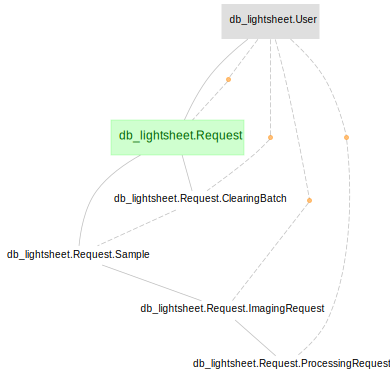

In [5]:
# Let's take a look at the schema design to get an overview of the tables and their relationships
dj.ERD(db_lightsheet.User) + 1 

**Note1: If you hover over the table name in the above diagram you can see what the columns of the table are.** 

**Note2: The above diagram is not the entire schema. dj.ERD(db_lightsheet) will show all tables, but it is a bit cumbersome to show in a single notebook cell** 

At the top is the User table, which simply contains usernames (netids) and emails of anyone who has submitted a request. The Request table is probably the most important table because all other tables (besides User) inherit from it. We will see what this means when we try to extract information from subsequent tables. First, let's take a look at the contents of the Request table for a specific user. 

<a id="requests"></a>
## Requests

In [6]:
username = 'jverpeut' # change this if you want to look up requests from a different netid
db_lightsheet.Request() & {'username':username} 

username user in the lab,request_name,requested_by user in the lab,date_submitted The date it was submitted as a request,time_submitted The time it was submitted as a request,labname,correspondence_email,description,species,number_of_samples,testing,is_archival
jverpeut,10032019_CNOtest,jverpeut,2019-10-03,17:58:52,Wang,jverpeut@princeton.edu,Stain for cFOS to understand effects of CNO.,mouse,1,0,1
jverpeut,AdultChronicD_MLI_Lawrence_(1-12_each_batch),jverpeut,2019-03-27,12:45:44,Wang,jverpeut@princeton.edu,detect c-Fos,mouse,12,0,1
jverpeut,an1-31,jverpeut,2019-03-07,23:31:33,Wang,jverpeut@princeton.edu,Recover mcherry expression in cerebellum. Morphology analysis.,mouse,28,0,1
jverpeut,CDymaze_1-10,jverpeut,2019-10-25,15:51:14,Wang,jverpeut@princeton.edu,TWO PRIMARY ANTIBODIES!! Recovery mcherry AND stain for c-Fos.,mouse,10,0,1
jverpeut,cruslat_ymaze_TiffanyP_6.20.19_(12_samples),jverpeut,2019-06-17,21:11:08,Wang,jverpeut@princeton.edu,cfos immunostaining and DREADD recovery,mouse,12,0,1
jverpeut,cruslat_ymaze_TiffanyP_6.20.19_(13_samples),jverpeut,2019-06-17,21:15:32,Wang,jverpeut@princeton.edu,cfos immunostaining and DREADD recovery,mouse,13,0,1
jverpeut,DREADDymaze,jverpeut,2019-02-26,12:55:22,Wang,jverpeut@princeton.edu,Image c-fos in whole brains at 1.3x.,mouse,33,0,1
jverpeut,EAAT4-_14_samples,jverpeut,2019-03-19,16:20:06,Wang,jverpeut@princeton.edu,Look for cerebellar banding. GFP,mouse,14,0,1
jverpeut,LindsayCrusI_ymaze_cfos_(25_samples),jverpeut,2019-03-27,12:42:21,Wang,jverpeut@princeton.edu,Detect c-fos.,mouse,25,0,1
jverpeut,mcherryDymaze_1-14,jverpeut,2020-01-09,16:43:06,Wang,jverpeut@princeton.edu,visualize dreadd expression and cfos post experiment,mouse,14,0,1


Here we see that the user "jverpeut" has 17 requests in the database. Looking at the columns of this table, we see that this request table contains the most basic information about your requests to the Core Facility, such as: date and time submitted, the purpose of the request ("description"), the species, and the number of samples in the request. This is the information we collect when you fill out a "New Request" form in the Lightserv web portal. Most of the information displayed in the "All requests" dashboard on Lightserv: https://braincogs00.pni.princeton.edu/requests/all_requests comes from this Request table

To get more detailed information about the samples in your requests, let's look at the Part tables (descendents in the ERD above) coming off of the Request table. First let's look at the Sample table for one of the requests above. 

In [7]:
request_name='natneuroreviews_tompisano_CTB' # change this if you want to look at a different request
db_lightsheet.Request.Sample() & {'username':username,'request_name':request_name}
# notice the syntax used. Sample is a part table of Request, hence the Request.Sample() syntax

username user in the lab,request_name,sample_name,clearing_protocol,antibody1,antibody2,clearing_batch_number,subject_fullname
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,iDISCO+_immuno,Everything but the antibody for the same amount of time as normal immuno.,Everything but the antibody for the same amount of time as normal immuno.,1,
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,iDISCO+_immuno,Everything but the antibody for the same amount of time as normal immuno.,Everything but the antibody for the same amount of time as normal immuno.,1,


We can see from this table that the request 'natneuroreviews_tompisano_CTB' by 'jverpeut' contains two samples, one represented by each row in this table. The samples are named 'natneuroreviews_tompisano_CTB-001' and 'natneuroreviews_tompisano_CTB-002'. We see some clearing information as well, such as which clearing protocol and antibodies were used when clearing these samples. 

The "subject_fullname" column represents the name of the subject in the subject table in the u19_subject database (also on datajoint00.pni.princeton.edu). This is how we link the behavior and training information with the light sheet information for the same subject. In this case, neither of the animals in jverpeut's request came from a U19 cohort, so this column is empty.

There is a lot more clearing information stored in the database for samples, it's just not contained in this exact table. The Sample table is only meant to be a summary of the sample. In the next section we will go through these clearing tables.

In general, all of the part tables of the Request table can be broken down into 3 categories: clearing, imaging and processing. 
<a id='clearing'></a>
## Clearing
The first table below Request in the diagram at the top is the ClearingBatch table. This table provides information about what clearing took place for the samples in your request.

In [8]:
db_lightsheet.Request.ClearingBatch() & {'username':username,'request_name':request_name}

username user in the lab,request_name,clearing_protocol,antibody1,antibody2,clearing_batch_number,clearing_progress,number_in_batch,perfusion_date,expected_handoff_date,clearer user in the lab,notes_for_clearer,link_to_clearing_spreadsheet
jverpeut,natneuroreviews_tompisano_CTB,iDISCO+_immuno,Everything but the antibody for the same amount of time as normal immuno.,Everything but the antibody for the same amount of time as normal immuno.,1,complete,2,2020-07-13,2020-07-14,ll3,Samples should be treated the same as any iDisco immuno sample.,None


The ClearingBatch table contains information about the clearing protocol and antibodies used for a given request. It also contains the column "clearer" which is the netid of the person who actually performed the clearing. Most of the time this will be "ll3", the netid for Laura Lynch. A Request can have more than one clearing batch. For example, if half of your samples needed one clearing protocol and the other half needed a different clearing protocol.

For requests submitted before July 2020, the "link_to_clearing_spreadsheet" column contains a link to google spreadsheets where the detailed clearing log for your request is contained. This log contains the dates and times for each of the steps in the clearing process that took place for your samples in that clearing batch. 

For requests submitted through the Lightserv web portal, the clearing log is stored in a database table. 

We see that the for jverpeut's request above, the clearing protocol is "iDISCO+_immuno", which refers to iDISCO+ with immunostaining. For this batch, the "link_to_clearing_spreadsheet" column is "None". The way we look up the clearing log in this case is through the clearing table. This was not listed in the schema diagram above, but we can see it if we expand around the ClearingBatch() table:

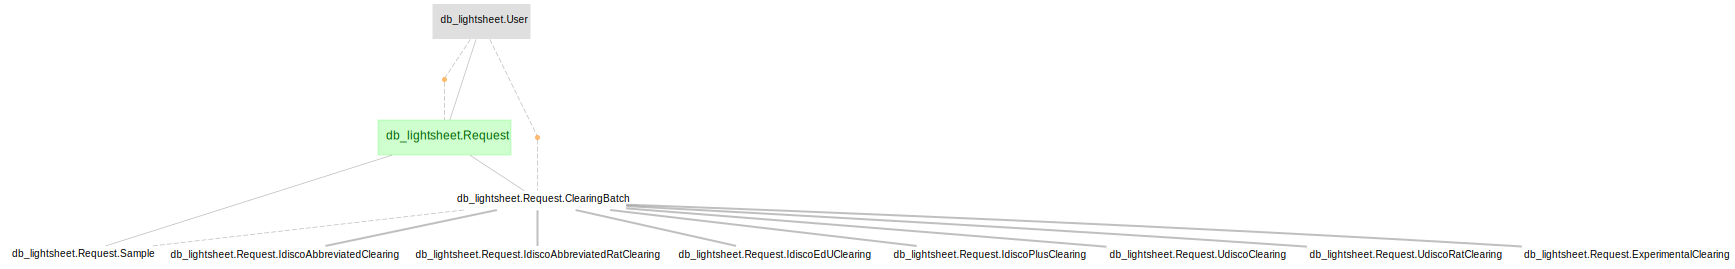

In [9]:
# Let's take a look at the schema design to get an overview of the tables and their relationships
dj.ERD(db_lightsheet.Request.ClearingBatch) + 1 - 1

Here we see all of the different clearing tables:
```
db_lightsheet.Request.IdiscoAbbreviatedClearing -- Abbreviated mouse brain clearing
db_lightsheet.Request.IdiscoAbbreviatedRatClearing -- Abbreviated rat brain clearing
db_lightsheet.Request.IdiscoPlusClearing -- iDISCO+ with immunostaining mouse brain clearing
db_lightsheet.Request.IdiscoEdUClearing -- Wang Lab iDISCO_EdU mouse brain clearing
db_lightsheet.Request.UdiscoRatClearing -- uDISCO rat brain clearing
db_lightsheet.Request.UdiscoClearing -- uDISCO mouse brain clearing
db_lightsheet.Request.ExperimentalClearing -- any clearing that does not fit into the above categories
```
In our case, we want to look at IdiscoPlusClearing. Hovering over that table in the above diagram we can see that it inherits its primary keys from the ClearingBatch() table. So to look at the clearing parameters for the request we singled out above we do:

In [10]:
db_lightsheet.Request.IdiscoPlusClearing & {'username':username,'request_name':request_name}

username user in the lab,request_name,clearing_protocol,antibody1,antibody2,clearing_batch_number,exp_notes Note anything unusual that happened during request handling that could affect clearing,time_dehydr_pbs_wash1,dehydr_pbs_wash1_notes,time_dehydr_pbs_wash2,dehydr_pbs_wash2_notes,time_dehydr_pbs_wash3,dehydr_pbs_wash3_notes,time_dehydr_methanol_20percent_wash1,dehydr_methanol_20percent_wash1_notes,time_dehydr_methanol_40percent_wash1,dehydr_methanol_40percent_wash1_notes,time_dehydr_methanol_60percent_wash1,dehydr_methanol_60percent_wash1_notes,time_dehydr_methanol_80percent_wash1,dehydr_methanol_80percent_wash1_notes,time_dehydr_methanol_100percent_wash1,dehydr_methanol_100percent_wash1_notes,time_dehydr_methanol_100percent_wash2,dehydr_methanol_100percent_wash2_notes,time_dehydr_peroxide_wash1,dehydr_peroxide_wash1_notes,time_rehydr_methanol_100percent_wash1,rehydr_methanol_100percent_wash1_notes,time_rehydr_methanol_80percent_wash1,rehydr_methanol_80percent_wash1_notes,time_rehydr_methanol_60percent_wash1,rehydr_methanol_60percent_wash1_notes,time_rehydr_methanol_40percent_wash1,rehydr_methanol_40percent_wash1_notes,time_rehydr_methanol_20percent_wash1,rehydr_methanol_20percent_wash1_notes,time_rehydr_pbs_wash1,rehydr_pbs_wash1_notes,time_rehydr_sodium_azide_wash1,rehydr_sodium_azide_wash1_notes,time_rehydr_sodium_azide_wash2,rehydr_sodium_azide_wash2_notes,time_rehydr_glycine_wash1,rehydr_glycine_wash1_notes,time_blocking_start_roomtemp,blocking_start_roomtemp_notes,time_blocking_donkey_serum,blocking_donkey_serum_notes,time_antibody1_start_roomtemp,antibody1_start_roomtemp_notes,time_antibody1_ptwh_wash1,antibody1_ptwh_wash1_notes,time_antibody1_ptwh_wash2,antibody1_ptwh_wash2_notes,time_antibody1_added,antibody1_added_notes,time_wash1_start_roomtemp,wash1_start_roomtemp_notes,time_wash1_ptwh_wash1,wash1_ptwh_wash1_notes,time_wash1_ptwh_wash2,wash1_ptwh_wash2_notes,time_wash1_ptwh_wash3,wash1_ptwh_wash3_notes,time_wash1_ptwh_wash4,wash1_ptwh_wash4_notes,time_wash1_ptwh_wash5,wash1_ptwh_wash5_notes,time_antibody2_added,antibody2_added_notes,time_wash2_start_roomtemp,wash2_start_roomtemp_notes,time_wash2_ptwh_wash1,wash2_ptwh_wash1_notes,time_wash2_ptwh_wash2,wash2_ptwh_wash2_notes,time_wash2_ptwh_wash3,wash2_ptwh_wash3_notes,time_wash2_ptwh_wash4,wash2_ptwh_wash4_notes,time_wash2_ptwh_wash5,wash2_ptwh_wash5_notes,time_clearing_methanol_20percent_wash1,clearing_methanol_20percent_wash1_notes,time_clearing_methanol_40percent_wash1,clearing_methanol_40percent_wash1_notes,time_clearing_methanol_60percent_wash1,clearing_methanol_60percent_wash1_notes,time_clearing_methanol_80percent_wash1,clearing_methanol_80percent_wash1_notes,time_clearing_methanol_100percent_wash1,clearing_methanol_100percent_wash1_notes,time_clearing_methanol_100percent_wash2,clearing_methanol_100percent_wash2_notes,time_clearing_dcm_66percent_methanol_33percent,clearing_dcm_66percent_methanol_33percent_notes,time_clearing_dcm_wash1,clearing_dcm_wash1_notes,time_clearing_dcm_wash2,clearing_dcm_wash2_notes,time_clearing_dbe,clearing_dbe_notes,time_clearing_new_tubes,clearing_new_tubes_notes,clearing_notes,time_wash1_ptwh_wash6,wash1_ptwh_wash6_notes,time_wash2_ptwh_wash6,wash2_ptwh_wash6_notes
jverpeut,natneuroreviews_tompisano_CTB,iDISCO+_immuno,Everything but the antibody for the same amount of time as normal immuno.,Everything but the antibody for the same amount of time as normal immuno.,1,,2020-07-15 10:04:00,,2020-07-15 14:10:00,,2020-07-15 12:00:00,,2020-07-20 10:08:00,,2020-07-20 11:02:00,,2020-07-20 11:58:00,,2020-07-20 12:52:00,,2020-07-20 14:22:00,,2020-07-20 15:19:00,,2020-07-21 16:18:00,,2020-07-22 09:24:00,,2020-07-22 10:29:00,,2020-07-22 11:18:00,,2020-07-22 12:11:00,,2020-07-22 13:04:00,,2020-07-22 13:51:00,,2020-07-22 14:37:00,,2020-07-22 15:29:00,,2020-07-22 16:21:00,,2020-07-24 13:52:00,hold at 37 degrees,2020-07-24 13:52:00,,2020-07-27 10:11:00,hold at 37 degrees,2020-07-27 10:24:00,,2020-07-27 11:23:00,,2020-07-27 12:33:00,,2020-08-0

This table contains a lot of columns. That is because the iDISCO+ clearing protocol has many steps. Each step has its own column for the datetime that step was started and another column for any notes the person doing the clearing left. The notes are usually reserved for issues that might have occurred during the steps, if they are entered at all. 

If your samples were cleared with a different clearing protocol, then you would substitute the IdiscoPlusClearing in the above query to the name of the table corresponding to the clearing protocol that was used for your sample. If you aren't sure, you can list all of the requests that were ever cleared with a certain protocol by doing: 

In [11]:
db_lightsheet.Request.IdiscoPlusClearing()

username user in the lab,request_name,clearing_protocol,antibody1,antibody2,clearing_batch_number,exp_notes Note anything unusual that happened during request handling that could affect clearing,time_dehydr_pbs_wash1,dehydr_pbs_wash1_notes,time_dehydr_pbs_wash2,dehydr_pbs_wash2_notes,time_dehydr_pbs_wash3,dehydr_pbs_wash3_notes,time_dehydr_methanol_20percent_wash1,dehydr_methanol_20percent_wash1_notes,time_dehydr_methanol_40percent_wash1,dehydr_methanol_40percent_wash1_notes,time_dehydr_methanol_60percent_wash1,dehydr_methanol_60percent_wash1_notes,time_dehydr_methanol_80percent_wash1,dehydr_methanol_80percent_wash1_notes,time_dehydr_methanol_100percent_wash1,dehydr_methanol_100percent_wash1_notes,time_dehydr_methanol_100percent_wash2,dehydr_methanol_100percent_wash2_notes,time_dehydr_peroxide_wash1,dehydr_peroxide_wash1_notes,time_rehydr_methanol_100percent_wash1,rehydr_methanol_100percent_wash1_notes,time_rehydr_methanol_80percent_wash1,rehydr_methanol_80percent_wash1_notes,time_rehydr_methanol_60percent_wash1,rehydr_methanol_60percent_wash1_notes,time_rehydr_methanol_40percent_wash1,rehydr_methanol_40percent_wash1_notes,time_rehydr_methanol_20percent_wash1,rehydr_methanol_20percent_wash1_notes,time_rehydr_pbs_wash1,rehydr_pbs_wash1_notes,time_rehydr_sodium_azide_wash1,rehydr_sodium_azide_wash1_notes,time_rehydr_sodium_azide_wash2,rehydr_sodium_azide_wash2_notes,time_rehydr_glycine_wash1,rehydr_glycine_wash1_notes,time_blocking_start_roomtemp,blocking_start_roomtemp_notes,time_blocking_donkey_serum,blocking_donkey_serum_notes,time_antibody1_start_roomtemp,antibody1_start_roomtemp_notes,time_antibody1_ptwh_wash1,antibody1_ptwh_wash1_notes,time_antibody1_ptwh_wash2,antibody1_ptwh_wash2_notes,time_antibody1_added,antibody1_added_notes,time_wash1_start_roomtemp,wash1_start_roomtemp_notes,time_wash1_ptwh_wash1,wash1_ptwh_wash1_notes,time_wash1_ptwh_wash2,wash1_ptwh_wash2_notes,time_wash1_ptwh_wash3,wash1_ptwh_wash3_notes,time_wash1_ptwh_wash4,wash1_ptwh_wash4_notes,time_wash1_ptwh_wash5,wash1_ptwh_wash5_notes,time_antibody2_added,antibody2_added_notes,time_wash2_start_roomtemp,wash2_start_roomtemp_notes,time_wash2_ptwh_wash1,wash2_ptwh_wash1_notes,time_wash2_ptwh_wash2,wash2_ptwh_wash2_notes,time_wash2_ptwh_wash3,wash2_ptwh_wash3_notes,time_wash2_ptwh_wash4,wash2_ptwh_wash4_notes,time_wash2_ptwh_wash5,wash2_ptwh_wash5_notes,time_clearing_methanol_20percent_wash1,clearing_methanol_20percent_wash1_notes,time_clearing_methanol_40percent_wash1,clearing_methanol_40percent_wash1_notes,time_clearing_methanol_60percent_wash1,clearing_methanol_60percent_wash1_notes,time_clearing_methanol_80percent_wash1,clearing_methanol_80percent_wash1_notes,time_clearing_methanol_100percent_wash1,clearing_methanol_100percent_wash1_notes,time_clearing_methanol_100percent_wash2,clearing_methanol_100percent_wash2_notes,time_clearing_dcm_66percent_methanol_33percent,clearing_dcm_66percent_methanol_33percent_notes,time_clearing_dcm_wash1,clearing_dcm_wash1_notes,time_clearing_dcm_wash2,clearing_dcm_wash2_notes,time_clearing_dbe,clearing_dbe_notes,time_clearing_new_tubes,clearing_new_tubes_notes,clearing_notes,time_wash1_ptwh_wash6,wash1_ptwh_wash6_notes,time_wash2_ptwh_wash6,wash2_ptwh_wash6_notes
jverpeut,natneuroreviews_set2_tompisano_HSV-H129,iDISCO+_immuno,1:2200 Rabbit anti-HSV,1:625 Donkey anti-Rabbit AlexaFluor 647,1,,2020-08-27 15:46:00,,2020-08-28 09:42:00,,2020-08-28 11:46:00,,2020-08-31 11:35:00,,2020-08-31 12:28:00,,2020-08-31 13:18:00,,2020-08-31 14:13:00,,2020-08-31 15:01:00,,2020-08-31 16:24:00,,2020-09-01 14:37:00,,2020-09-02 10:38:00,,2020-09-02 11:26:00,,2020-09-02 12:12:00,,2020-09-02 14:07:00,,2020-09-02 14:50:00,,2020-09-02 15:36:00,,2020-09-02 16:25:00,,2020-09-02 17:12:00,,2020-09-02 18:02:00,,2020-09-08 08:19:00,samples held at 37 degrees; buffer prepared 9/3/20 and left at 37 degrees until 9/8/20,2020-09-08 08:22:00,,2020-09-10 12:14:00,hold at 37 degrees,2020-09-10 12:14:00,,2020-09-10 13:37:00,,2020-09-10 14:49:00,13.6 ul rabbit an

And then checking to see whether your request is there. 

<a id='imaging'></a>
## Imaging
The next part table below Request in the schema displayed at the top of this notebook is the ImagingRequest table. This table provides information about what imaging took place for the samples in your request. Let's expand out the schema around a part table called ImagingResolutionRequest (not present in the first diagram) to see the whole chain of imaging tables.

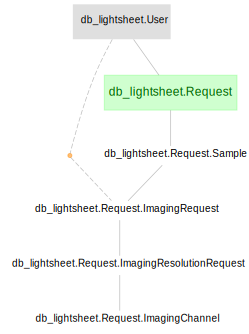

In [12]:
dj.ERD(db_lightsheet.Request.ImagingResolutionRequest) + 1 - 2

Here we see the entire chain of tables for the imaging part of this schema. ImagingRequest table is like the ClearingBatch table but for imaging. The difference here is that each sample has an ImagingRequest because samples are imaged individually whereas samples are often clearing in the same batch. Let's look at the ImagingRequest table:

In [13]:
db_lightsheet.Request.ImagingRequest() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,imager user in the lab,imaging_request_date_submitted date that the user submitted the request for imaging,imaging_request_time_submitted time that the user submitted the request for imaging,imaging_performed_date date that the imaging form was submitted by the imager,imaging_progress
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,zmd,2020-07-05,13:51:17,None,in progress
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,None,2020-07-05,13:51:17,None,incomplete


Here we can see the two samples from the request we looked at before in the clearing tables. The "imager" column shows the netid of the person who performed the imaging. It lists None if the imaging has not been started yet. The progress of the imaging is shown in the last column "imaging_progress". In this case zmd (Zahra Dhanerawala's netid) is in the process of imaging the first sample and the second sample has not been started yet. 

You'll notice that there is no information about what microscope or image resolutions or laser wavelengths were used. That information is contained in other tables. 

The ImagingResolutionRequest table contains part of this information:

In [14]:
db_lightsheet.Request.ImagingResolutionRequest() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,image_resolution,microscope,notes_for_imager,notes_from_imaging
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,4x,None,,
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,4x,None,,


Here we see that the image_resolution of these two samples that was requested by 'jverpeut' is 4x. The microscope column was not added to the database yet when jverpeut made this request. Only very recent requests will have information here, but the microscope can be inferred from the image resolution. Only "3.6x" and "15x" requests use the SmartSPIM microscope. All other requests use the LaVision microscope. 

The "notes_for_imager" column is empty here. This column is populated from the "New Request" form. There is a section where you can write a note for the imager to see if you want something particular done during imaging. In this case, no note was necessary. The "notes_from_imaging" column is used by the imager to report any irregularities during imaging. For images taken before Lightserv, we use this column to report where the processed images live on bucket. Here is an example of the contents of this column for an older request:

In [15]:
request_contents = db_lightsheet.Request.ImagingResolutionRequest() & \
    {'username':'ejdennis','request_name':'201905_atlas00x_where_x=1:n'}
request_contents.fetch1('notes_from_imaging')

'Processed files are here: /jukebox/LightSheetData/brodyatlas/processed'

The reason ImagingRequest and ImagingResolutionRequest are different tables is because a single request can consist of multiple image resolutions, even for the same brain sample. Similarly, we have another table, ImagingChannel(), which contains the different channels (laser wavelengths) used at a given image resolution.

In [16]:
db_lightsheet.Request.ImagingChannel() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,image_resolution,channel_name,imaging_date,zoom_body_magnification only applicable for 2x,left_lightsheet_used,right_lightsheet_used,registration,injection_detection,probe_detection,cell_detection,generic_imaging,pixel_type,image_orientation how the imager imaged the sample. Most of the time will be horizontal,numerical_aperture it is not always recorded in metadata so those times it will be NULL,tiling_scheme,tiling_overlap,z_step distance between z planes in microns,number_of_z_planes,rawdata_subfolder,"imspector_channel_index refers to multi-channel imaging - 0 if first (or only) channel in rawdata_subfolder, 1 if second, 2 if third, ...",left_lightsheet_precomputed_spock_jobid,left_lightsheet_precomputed_spock_job_progress,right_lightsheet_precomputed_spock_jobid,right_lightsheet_precomputed_spock_job_progress
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,4x,488,None,nan,1,1,1,0,0,0,0,None,sagittal,nan,1x1,0.0,10.0,None,None,None,None,None,None,None
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,4x,555,None,nan,1,1,0,1,0,0,0,None,sagittal,nan,1x1,0.0,10.0,None,None,None,None,None,None,None
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,4x,488,None,nan,1,1,1,0,0,0,0,None,sagittal,nan,1x1,0.0,10.0,None,None,None,None,None,None,None
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,4x,555,None,nan,1,1,0,1,0,0,0,None,sagittal,nan,1x1,0.0,10.0,None,None,None,None,None,None,None


Here we can see that jverpeut requested two imaging channels: 488 and 555 (first two rows) for the first sample and the same two channels for the second sample (last two rows). This table also contains a lot more information about the imaging, such as the date on which it was imaged ("None" in this case since the imaging was not performed yet), which lightsheets were used via columns: "left_lightsheet_used" and "right_lightsheet_used", with boolean values where a 0 means not used and 1 means used. The columns: 
```
registration
injection_detection
probe_detection
cell_detection
generic_imaging
```
refer to what the intended purpose of this imaging channel is. They are also boolean values. For example, when registration=1, it means that this channel was used as a registration channel - in other words use this channel to register the data to an atlas. A channel can have more than one purpose. These columns are determined by how you fill out the imaging table in the "New Request" form on the Lightserv web portal. 

Other information in this table includes the tiling scheme, the "z_step" or the distance in microns between z planes, the number of z planes, the "rawdata_subfolder" on bucket where the raw data will be stored, and spock job numbers and progresses for programs used internally by the Lightserv app for converting the raw data so it can be visualized with Neuroglancer. 

That is it for the imaging section of the database. Now let's move on to the final section, processing.

<a id='processing'></a>
## Processing
As with clearing and imaging, we can isolate the part of the database schema dealing with processing.

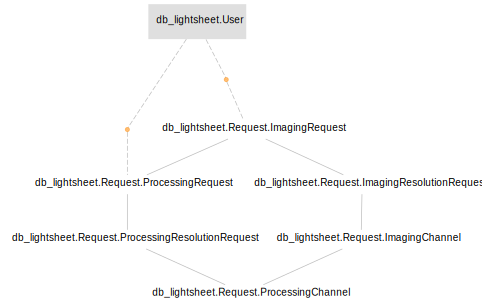

In [17]:
dj.ERD(db_lightsheet.Request.ProcessingResolutionRequest) + 1 - 2

We can see that the processing tables depend on some of the imaging tables. This is because what we are processing is images. The three processing tables that are used in this schema are:
```
db_lightsheet.Request.ProcessingRequest
db_lightsheet.Request.ProcessingResolutionRequest
db_lightsheet.Request.ProcessingChannel
```

These mirror the functions of the three imaging tables we just went over:
```
db_lightsheet.Request.ImagingRequest
db_lightsheet.Request.ImagingResolutionRequest
db_lightsheet.Request.ImagingChannel
```
Let's take a look at the first of these, ProcessingRequest:

In [18]:
db_lightsheet.Request.ProcessingRequest() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,processing_request_number,processor user in the lab,processing_request_date_submitted date that the user submitted the request for processing,processing_request_time_submitted time that the user submitted the request for processing,processing_performed_date date that the processing form was submitted by the processor,processing_progress
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,1,jverpeut,2020-07-05,13:51:17,None,incomplete
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,1,jverpeut,2020-07-05,13:51:17,None,incomplete


We see that each sample has its own row in this table. The "processor" is the person assigned to perform the image processing. This is by default set to the owner of the request, i.e. the person who submitted the request. The reason for this is so that you can control when and how you want to run the processing pipeline. By "run the pipeline" we just mean fill out a form and press submit. You don't have to run any code yourself. 

We also see columns for when the processing was performed and the processing progress. For both of these samples, the processing hasn't started yet (because the imaging has not been performed for these samples yet).

Let's look at the next table, ProcessingResolutionRequest

In [19]:
db_lightsheet.Request.ProcessingResolutionRequest() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,processing_request_number,image_resolution,atlas_name,final_orientation,notes_for_processor,notes_from_processing,lightsheet_pipeline_spock_jobid the jobid from the final step in the light sheet processing pipeline,lightsheet_pipeline_spock_job_progress the spock job status code for the final step in the light sheet processing pipeline,brainpipe_commit the commit that is checked out on the machine at the time the job was submitted
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-001,1,1,4x,princeton_mouse_atlas,sagittal,,,None,None,None
jverpeut,natneuroreviews_tompisano_CTB,natneuroreviews_tompisano_CTB-002,1,1,4x,princeton_mouse_atlas,sagittal,,,None,None,None


When we run BrainPipe (the image processing and atlas registration code) on your images, we group the imaging channels in a request that were taken at the same resolution together and run them in one go. Each row in this table represents a different run of the code. For the samples in this example, we haven't run the code yet because the images haven't been taken yet, but the column names reflect what kind of data to expect. We have the "atlas_name" column which tells you which atlas your data will be registered to. We also have "lighsheet_pipeline_spock_jobid", the jobid on PNI's high performance computer, Spock, that ran the code, and "brainpipe_commit", which is the github commit of https://github.com/BrainCOGS/BrainPipe at the time the code was run for your samples.

Each ProcessingRequest entry can consist of multiple ProcessingChannel entries. The ProcessingChannel is only populated when the BrainPipe code is run, so no data are present for the request we have been looking at in this notebook. Still, we can look at the columns for this table anyway:

In [20]:
db_lightsheet.Request.ProcessingChannel() & {'username':username,'request_name':request_name}

username user in the lab,request_name,sample_name,imaging_request_number,image_resolution,channel_name,processing_request_number,lightsheet_channel_str,imspector_version,datetime_processing_started,datetime_processing_completed,intensity_correction,metadata_xml_string The entire metadata xml string. Sometimes it is not available so those times it will be NULL,left_lightsheet_stitched_precomputed_spock_jobid,left_lightsheet_stitched_precomputed_spock_job_progress,right_lightsheet_stitched_precomputed_spock_jobid,right_lightsheet_stitched_precomputed_spock_job_progress,blended_precomputed_spock_jobid,blended_precomputed_spock_job_progress,downsized_precomputed_spock_jobid,downsized_precomputed_spock_job_progress,registered_precomputed_spock_jobid,registered_precomputed_spock_job_progress


Each row of this table corresponds to a channel that was processed. The information here is used internally in the Lightserv app and may not be useful to you. 

That ends this tutorial. We have covered all of the tables in the lightsheet database. If you have any comments or suggestions about this tutorial, please contact lightservhelper@gmail.com

<a id='shortcuts'></a>
# Shortcuts

#### Q. Where are my images?
A. If your request was submitted through the Lightserv web portal (i.e. the "is_archival" column in the request table is 0), then all of your images (raw and processed) are kept on bucket under `/jukebox/LightSheetData/lightserv/{username}/{request_name}/{sample_name}/`

If it is an older request ("archival" column is 1), your data are stored in the folders you or someone from the Core Facility moved them to on bucket. Fortunately, we were able to keep track of at least the processed folder locations (the raw data may no longer exist and unfortunately were not tracked before Lightserv was developed). You can find the location of your processed data via:

In [21]:
username1 = 'ejdennis' # change as needed
request_name1 = '201905_atlas00x_where_x=1:n' # change as needed
# Let's check the archival column of this request
request_contents = db_lightsheet.Request() & \
    {'username':username1,'request_name':request_name1}
print("is_archival column = ",request_contents.fetch1('is_archival'))
contents = db_lightsheet.Request.ImagingResolutionRequest() & \
    {'username':username1,'request_name':request_name1}
contents.fetch(as_dict=True)

is_archival column =  1


[{'username': 'ejdennis',
  'request_name': '201905_atlas00x_where_x=1:n',
  'sample_name': 'sample-001',
  'imaging_request_number': 1,
  'image_resolution': '1.3x',
  'microscope': None,
  'notes_for_imager': '',
  'notes_from_imaging': 'Processed files are here: /jukebox/LightSheetData/brodyatlas/processed'}]

Here we see a list of dictionaries where the "notes_from_imaging" key contains the path to our processed data. If there were more than one sample in this request then we would have more than one dictionary

#### Q. Who cleared, imaged and processed my data?

In [22]:
username2 = 'ejdennis' # change as needed
request_name2 = 'three_female_atlas_brains' # change as needed
sample_contents = db_lightsheet.Request.Sample() & \
    {'username':username2,'request_name':request_name2}
print(f"Have {len(sample_contents)} samples in this request:\n {sample_contents.fetch('sample_name')}")
clearing_batch_contents = db_lightsheet.Request.ClearingBatch() & \
    {'username':username2,'request_name':request_name2}
print(f"Have {len(clearing_batch_contents)} clearing batches in this request, each cleared by: {clearing_batch_contents.fetch('clearer')}")
imaging_request_contents = db_lightsheet.Request.ImagingRequest() & \
    {'username':username2,'request_name':request_name2}
imagers = imaging_request_contents.fetch('imager')
print(f"Samples each imaged by: {imagers} ",)
imaging_request_contents = db_lightsheet.Request.ImagingRequest() & \
    {'username':username2,'request_name':request_name2}
processing_request_contents = db_lightsheet.Request.ProcessingRequest() & \
    {'username':username2,'request_name':request_name2}
processors = processing_request_contents.fetch('processor')
print(f"Samples each processed by: {processors} ",)

Have 3 samples in this request:
 ['three_female_atlas_brains-001' 'three_female_atlas_brains-002'
 'three_female_atlas_brains-003']
Have 1 clearing batches in this request, each cleared by: ['ll3']
Samples each imaged by: ['zmd' 'zmd' 'zmd'] 
Samples each processed by: ['ejdennis' 'ejdennis' 'ejdennis'] 


#### Q. What stage are my samples at in the Core Facility?

In [23]:
username3 = 'ejdennis' # change as needed
request_name3 = 'three_female_atlas_brains' # change as needed
sample_contents = db_lightsheet.Request.Sample() & \
    {'username':username3,'request_name':request_name3}
print(f"Have {len(sample_contents)} samples in this request:\n {sample_contents.fetch('sample_name')}\n")
clearing_batch_contents = db_lightsheet.Request.ClearingBatch() & \
    {'username':username3,'request_name':request_name3}
clearing_progress = clearing_batch_contents.fetch1('clearing_progress')
print("Clearing progress is: ",clearing_progress)
imaging_request_contents = db_lightsheet.Request.ImagingRequest() & \
    {'username':username3,'request_name':request_name3}
imaging_progress = imaging_request_contents.fetch('imaging_progress')
print(f"Imaging progress is: {imaging_progress}")
processing_request_contents = db_lightsheet.Request.ProcessingRequest() & \
    {'username':username3,'request_name':request_name3}
processing_progress = processing_request_contents.fetch('processing_progress')
print(f"Processing progress is: {processing_progress}")

Have 3 samples in this request:
 ['three_female_atlas_brains-001' 'three_female_atlas_brains-002'
 'three_female_atlas_brains-003']

Clearing progress is:  complete
Imaging progress is: ['complete' 'complete' 'complete']
Processing progress is: ['incomplete' 'incomplete' 'incomplete']


#### Q. What resolutions/channels were imaged for my request?

In [24]:
username4 = 'ejdennis' # change as needed
request_name4 = 'three_female_atlas_brains' # change as needed
sample_contents = db_lightsheet.Request.Sample() & \
    {'username':username4,'request_name':request_name4}
print(f"Have {len(sample_contents)} samples in this request\n")
for sample_dict in sample_contents:
    sample_name = sample_dict['sample_name']
    imaging_channel_contents = db_lightsheet.Request.ImagingChannel() & \
        {'username':username4,'request_name':request_name4,'sample_name':sample_name}
    image_resolutions,channel_names = imaging_channel_contents.fetch('image_resolution','channel_name')
    print(f"Sample: {sample_name}:")
    for ii in range(len(image_resolutions)):
        image_resolution = image_resolutions[ii]
        channel_name = channel_names[ii]
        print(f"\tImage resolution: {image_resolution}\tChannel: {channel_name}")
    print()

Have 3 samples in this request

Sample: three_female_atlas_brains-001:
	Image resolution: 1.1x	Channel: 488

Sample: three_female_atlas_brains-002:
	Image resolution: 1.1x	Channel: 488

Sample: three_female_atlas_brains-003:
	Image resolution: 1.1x	Channel: 488

